In [111]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score

In [113]:
data = pd.read_csv('fastball.csv')

# Exploring the data

In [101]:
data.shape

(2867154, 9)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867154 entries, 0 to 2867153
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   b_score    float64
 1   b_count    float64
 2   s_count    float64
 3   outs       float64
 4   pitch_num  float64
 5   on_1b      float64
 6   on_2b      float64
 7   on_3b      float64
 8   fastball   int64  
dtypes: float64(8), int64(1)
memory usage: 196.9 MB


In [103]:
data.head()

,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,fastball
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1
2,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,1
3,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,1
4,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,0


In [27]:
#housing.drop_duplicates(inplace=True)

In [28]:
#df1 = housing[['px', 'pz', 'zone','code','type','pitch_type','b_score','b_count','s_count','outs','pitch_num','on_1b','on_2b','on_3b']]
#df1 = housing[['b_score','b_count','s_count','outs','pitch_num','on_1b','on_2b','on_3b']]

In [36]:
#df1.head()

We remove the columns above because we're attempting to forecast sales, and these columns contain information that can only be obtained after a home has been sold.

## Numerical

In [14]:
df1.select_dtypes(exclude=['object']).isna().sum()

b_score      0
b_count      0
s_count      0
outs         0
pitch_num    0
on_1b        0
on_2b        0
on_3b        0
dtype: int64

We don't have to deal with any new numerical columns with missing data. To maintain consistency, we will remove the 8 rows, as we did in iteration 5.

In [8]:
#housing = housing[housing['MasVnrArea'].notna()].copy()

## Categorical

In [15]:
df1.select_dtypes(include=['object']).shape

(2867154, 0)

In [16]:
df1.select_dtypes(include=['object']).isna().sum()

Series([], dtype: float64)

### Dealing with the missing data from the new categorical columns

To make a better decision about how to treat missing values, we should first determine which of these columns are ordinal.

#### Ordinal

#### Categorical

* Alley - NA is a category (No alley access)
* MiscFeature - NA is a category (None)
* GarageType - NA is a feature (No Garage)

We can therefore let the imputer enter these values for us

# Models

## Decision Tree

In [104]:
X = data
y = X.pop("fastball")

In [106]:
y

0          1
1          1
2          1
3          1
4          0
          ..
2867149    0
2867150    1
2867151    1
2867152    1
2867153    1
Name: fastball, Length: 2867154, dtype: int64

In [107]:
def impute_categ_nulls(df):
    df = df.fillna("N_A")
    return df

cat_imputer = FunctionTransformer(impute_categ_nulls, validate=False)

In [90]:
# VarianceThreshold removes all features with a low variance.
from sklearn.feature_selection import VarianceThreshold

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[

    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    StandardScaler(),
    VarianceThreshold(),
    SelectKBest(f_classif),
    DecisionTreeClassifier()
)

pipe_params = {
    'selectkbest__k': [2, 4, 6],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [3,5,7],
    'decisiontreeclassifier__min_samples_split': [2, 4],
    'decisiontreeclassifier__min_samples_leaf': [1, 2]
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 5, verbose=2, scoring='f1')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2, selectkbest__k=2; total time=   3.9s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2, selectkbest__k=2; total time=   3.9s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2, selectkbest__k=2; total time=   3.7s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2, selectkbest__k=2; total time=   3.7s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, deci

[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=4; total time=   3.7s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=6; total time=   4.3s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=6; total time=   4.2s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=6; total time=   4.2s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=3, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier

[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=4, selectkbest__k=2; total time=   3.6s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=4, selectkbest__k=2; total time=   3.6s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=4, selectkbest__k=4; total time=   4.1s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=4, selectkbest__k=4; total time=   4.1s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier

[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=4, selectkbest__k=6; total time=   5.4s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=4, selectkbest__k=6; total time=   5.5s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=5, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=4, selectkbest__k=6; total time=   5.0s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier__min_samples_split=2, selectkbest__k=2; total time=   3.9s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=1, decisiontreeclassifier

[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=4; total time=   5.8s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=4; total time=   5.7s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=4; total time=   5.9s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier__min_samples_split=2, selectkbest__k=4; total time=   6.0s
[CV] END decisiontreeclassifier__criterion=gini, decisiontreeclassifier__max_depth=7, decisiontreeclassifier__min_samples_leaf=2, decisiontreeclassifier

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 7,
 'decisiontreeclassifier__min_samples_leaf': 2,
 'decisiontreeclassifier__min_samples_split': 2,
 'selectkbest__k': 6}

In [91]:
y_pred = clf.predict(X_test)

dtc_accuracy = accuracy_score(y_test, y_pred)
dtc_accuracy

0.6888256826017428

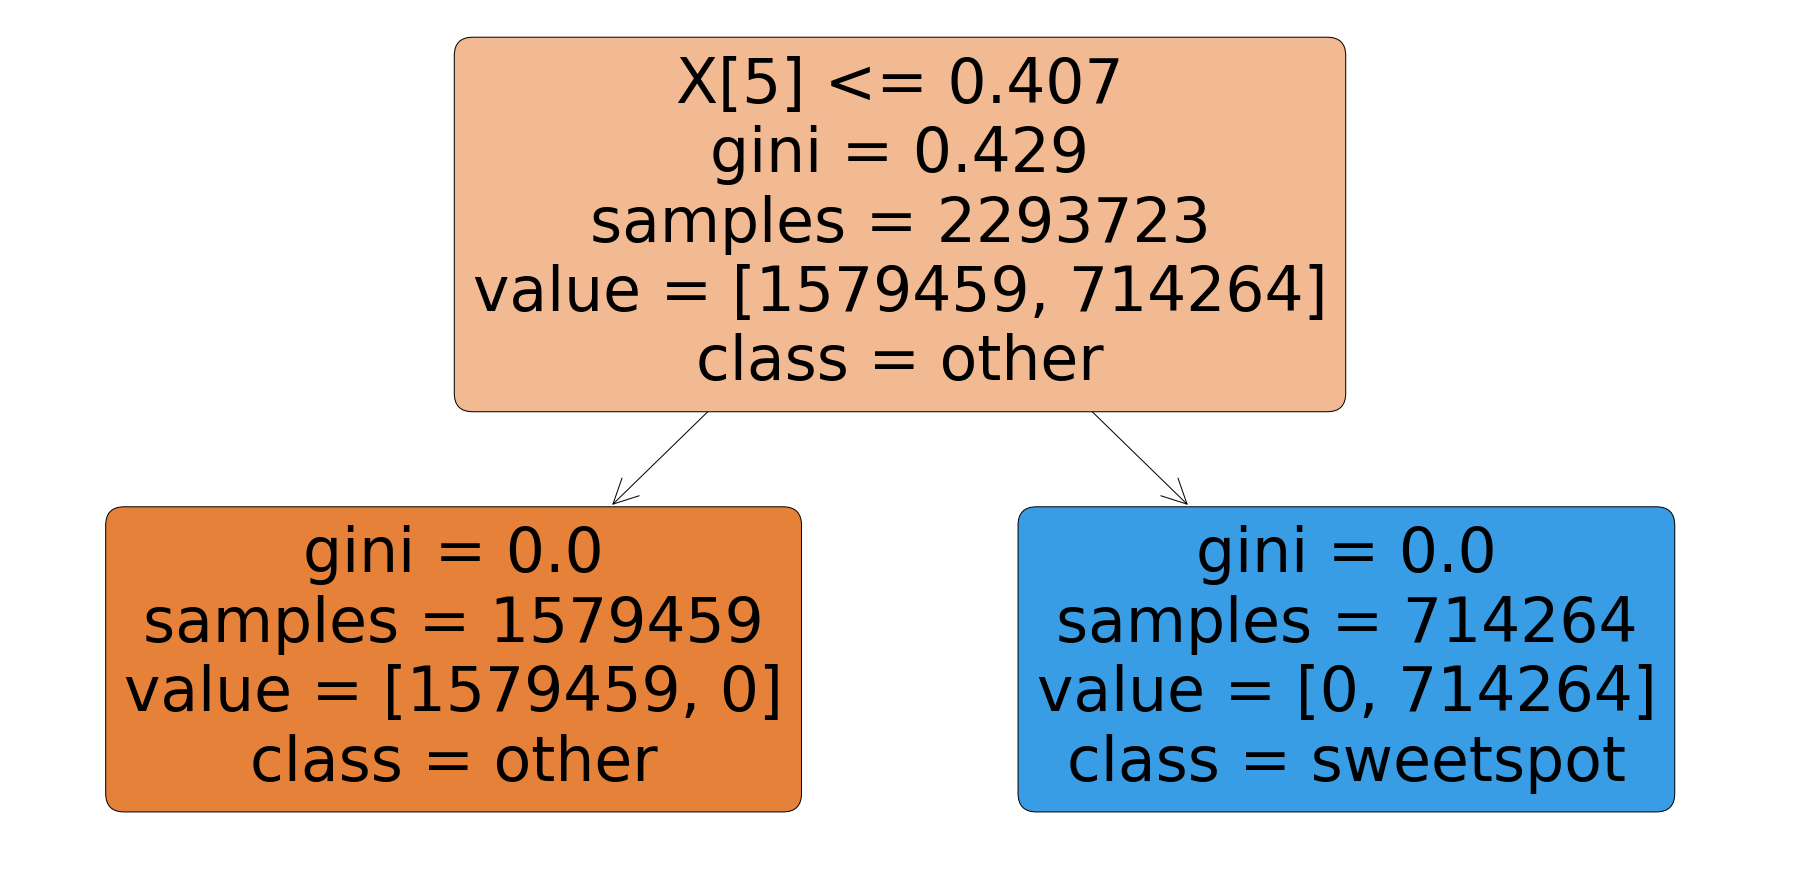

In [61]:

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(32, 16))
plot_tree(
    clf.best_estimator_.named_steps['decisiontreeclassifier'],
    filled=True, 
    rounded=True, 
    class_names=['other','sweetspot'], 

    );

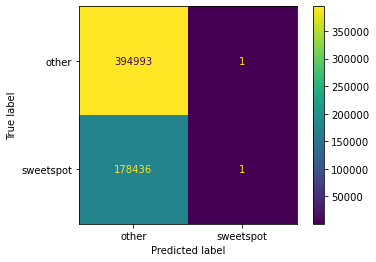

In [92]:
from sklearn.metrics import plot_confusion_matrix ## for sklearn older than  1.0 version
plot_confusion_matrix(clf, X_test, y_test, display_labels=['other', 'sweetspot']);

In [62]:
from sklearn.metrics import confusion_matrix

def model_check(y_true, y_preds, model):     
    tn, fp, fn, tp = confusion_matrix(y_true, y_preds).ravel()
    return tn, fp, fn, tp
tn, fp, fn, tp = model_check(y_test, clf.predict(X_test), clf)

In [63]:
from sklearn.metrics import precision_score, recall_score, cohen_kappa_score, f1_score

dtc_accuracy = accuracy_score(clf.predict(X_test), y_test)
dtc_sensitivity = recall_score(clf.predict(X_test), y_test)
dtc_precision = precision_score(clf.predict(X_test), y_test)
dtc_specificity = tn / (tn+fp)
dtc_f_score = f1_score(clf.predict(X_test), y_test)
dtc_cohen_score = cohen_kappa_score(y_test, y_pred)

dtc_metrics = f"""
Accuracy: {dtc_accuracy}
Recall/Sensitivity (True Positive Rate): {dtc_sensitivity}
Precision (TP / (TP + FP)): {dtc_precision}
Specificity: (True Negative Rate): {dtc_specificity}
F Score: {dtc_f_score}
Cohen Kappa: {dtc_cohen_score}
"""
print(dtc_metrics)


Accuracy: 1.0
Recall/Sensitivity (True Positive Rate): 1.0
Precision (TP / (TP + FP)): 1.0
Specificity: (True Negative Rate): 1.0
F Score: 1.0
Cohen Kappa: 1.0



## Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[

    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    StandardScaler(),
    VarianceThreshold(),
    SelectKBest(f_classif),
    LogisticRegression()
)

pipe_params = {
    'selectkbest__k': [3,5,7],
    'logisticregression__max_iter': [1000],
    'logisticregression__C': [1.0, 2.0, 3.0],
    'logisticregression__class_weight': ['auto', 'balanced']
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 5, verbose=2, scoring='f1')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   4.8s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   4.5s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   5.0s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   6.4s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   5.0s
[CV] END logisticregression__C=1.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=5; total time=   4.6s
[CV] END logisticregression__C=1.0, logisticregression__c

[CV] END logisticregression__C=2.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, selectkbest__k=7; total time=   5.7s
[CV] END logisticregression__C=2.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, selectkbest__k=7; total time=   7.7s
[CV] END logisticregression__C=2.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, selectkbest__k=7; total time=   6.8s
[CV] END logisticregression__C=2.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, selectkbest__k=7; total time=   8.3s
[CV] END logisticregression__C=2.0, logisticregression__class_weight=balanced, logisticregression__max_iter=1000, selectkbest__k=7; total time=   6.6s
[CV] END logisticregression__C=3.0, logisticregression__class_weight=auto, logisticregression__max_iter=1000, selectkbest__k=3; total time=   5.4s
[CV] END logisticregression__C=3.0, logisticregression__class_weight=auto, logisticregression__max

{'logisticregression__C': 1.0,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__max_iter': 1000,
 'selectkbest__k': 3}

In [72]:
y_pred = clf.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)
lr_accuracy

1.0

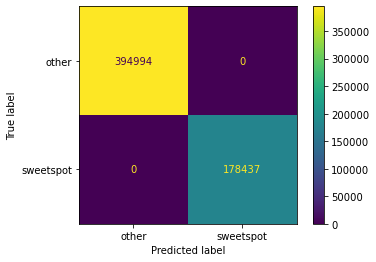

In [75]:
from sklearn.metrics import plot_confusion_matrix ## for sklearn older than  1.0 version
plot_confusion_matrix(clf, X_test, y_test, display_labels=['other', 'sweetspot']);

In [76]:
tn, fp, fn, tp = model_check(y_test, clf.predict(X_test), clf)

lr_accuracy = accuracy_score(clf.predict(X_test), y_test)
lr_sensitivity = recall_score(clf.predict(X_test), y_test)
lr_precision = precision_score(clf.predict(X_test), y_test)
lr_specificity = tn / (tn+fp)
lr_f_score = f1_score(clf.predict(X_test), y_test)
lr_cohen_score = cohen_kappa_score(y_test, y_pred)

lr_metrics = f"""
Accuracy: {lr_accuracy}
Recall/Sensitivity (True Positive Rate): {lr_sensitivity}
Precision (TP / (TP + FP)): {lr_precision}
Specificity: (True Negative Rate): {lr_specificity}
F Score: {lr_f_score}
Cohen Kappa: {lr_cohen_score}
"""
print(lr_metrics)


Accuracy: 1.0
Recall/Sensitivity (True Positive Rate): 1.0
Precision (TP / (TP + FP)): 1.0
Specificity: (True Negative Rate): 1.0
F Score: 1.0
Cohen Kappa: 1.0



## Random Forest Classifier

In [108]:
from sklearn.ensemble import RandomForestClassifier

numeric_features = list(X.select_dtypes(exclude=["object"]))

numeric_pipe = make_pipeline(
    SimpleImputer(strategy="median")
)

#categorical_features_ordinal = ordinal_columns
#categorical_transformer_ordinal = OrdinalEncoder(categories=cats_ord)
#categorical_features_onehot = list(set(list(X.select_dtypes(include=["object"]))) - set(ordinal_columns))
categorical_transformer_onehot = OneHotEncoder(handle_unknown="ignore")

categorical_preprocessor = ColumnTransformer(
    transformers=[
#        ("cat_ordinal", categorical_transformer_ordinal, categorical_features_ordinal),
#        ("cat_onehot", categorical_transformer_onehot, categorical_features_onehot),
    ]
)

categorical_pipe = make_pipeline(
    cat_imputer,
    categorical_preprocessor
)


cat_num_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_features),
        ("cat_pipe", categorical_pipe, list(X.select_dtypes(include=["object"]))),
    ]
)

final_pipe = make_pipeline(
    cat_num_preprocessor,
    StandardScaler(),
    VarianceThreshold(),
    SelectKBest(f_classif),
    RandomForestClassifier()
)

pipe_params = {
    'selectkbest__k': [2, 4, 6],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [3, 5, 7],
    'randomforestclassifier__max_depth': [2, 4],
    'randomforestclassifier__min_samples_leaf': [1, 2]
}

clf = GridSearchCV(final_pipe, pipe_params, cv = 5, verbose=2, scoring='f1')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X_train, y_train)

clf.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__min_samples_leaf=1, selectkbest__k=2; total time=  42.2s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__min_samples_leaf=1, selectkbest__k=2; total time=  57.9s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__min_samples_leaf=1, selectkbest__k=2; total time=  52.0s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__min_samples_leaf=1, selectkbest__k=2; total time= 1.2min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclassifier__min_samples_leaf=1, selectkbest__k=2; total time= 1.5min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=2, randomforestclass

[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=2; total time=  50.9s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=2, selectkbest__k=4; total time= 1.3mi

[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=4; total time= 1.3min
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=6; total time= 1.7min
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=6; total time= 1.7min
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=6; total time= 1.7min
[CV] END randomforestclassifier__criterion=entropy, randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, selectkbest__k=6;

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 4,
 'randomforestclassifier__min_samples_leaf': 2,
 'selectkbest__k': 4}

In [109]:
y_pred = clf.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred)
lr_accuracy

0.6487214677964742

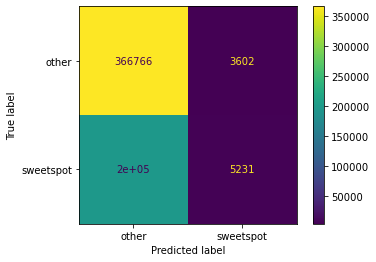

In [110]:
from sklearn.metrics import plot_confusion_matrix ## for sklearn older than  1.0 version
plot_confusion_matrix(clf, X_test, y_test, display_labels=['other', 'sweetspot']);

In [127]:
tn, fp, fn, tp = model_check(y_test, clf.predict(X_test), clf)

rfc_accuracy = accuracy_score(clf.predict(X_test), y_test)
rfc_sensitivity = recall_score(clf.predict(X_test), y_test)
rfc_precision = precision_score(clf.predict(X_test), y_test)
rfc_specificity = tn / (tn+fp)
rfc_f_score = f1_score(clf.predict(X_test), y_test)
rfc_cohen_score = cohen_kappa_score(y_test, y_pred)

svc_metrics = f"""
Accuracy: {rfc_accuracy}
Recall/Sensitivity (True Positive Rate): {rfc_sensitivity}
Precision (TP / (TP + FP)): {rfc_precision}
Specificity: (True Negative Rate): {rfc_specificity}
F Score: {rfc_f_score}
Cohen Kappa: {rfc_cohen_score}
"""
print(svc_metrics)


Accuracy: 0.6487214677964742
Recall/Sensitivity (True Positive Rate): 0.5922110268312012
Precision (TP / (TP + FP)): 0.02576047827521508
Specificity: (True Negative Rate): 0.9902745377570417
F Score: 0.04937327745686563
Cohen Kappa: 0.020453828757782233



# Comparison of models

In [129]:
results = {
'model': ['decision_tree', 'logistic_regression', 'random forest'],
'accuracy': [dtc_accuracy, lr_accuracy, rfc_accuracy],
'sensitivity': [dtc_sensitivity, lr_sensitivity, rfc_sensitivity],
'precision': [dtc_precision, lr_precision, rfc_precision],
'specificity': [dtc_specificity, lr_specificity, rfc_specificity],
'f_score': [dtc_f_score, lr_f_score, rfc_f_score],
'cohen_kappa': [dtc_cohen_score, lr_cohen_score, rfc_cohen_score]
}
results = pd.DataFrame(results)
results.set_index('model', inplace=True)
results

,accuracy,sensitivity,precision,specificity,f_score,cohen_kappa
model,,,,,,
decision_tree,0.688826,1.000000,1.00000,1.000000,1.000000,1.000000
logistic_regression,0.648721,1.000000,1.00000,1.000000,1.000000,1.000000
random forest,0.648721,0.592211,0.02576,0.990275,0.049373,0.020454


In [130]:
# transpose the dataframe
results = results.T
results

model,decision_tree,logistic_regression,random forest
accuracy,0.688826,0.648721,0.648721
sensitivity,1.000000,1.000000,0.592211
precision,1.000000,1.000000,0.025760
specificity,1.000000,1.000000,0.990275
f_score,1.000000,1.000000,0.049373
cohen_kappa,1.000000,1.000000,0.020454


<AxesSubplot:>

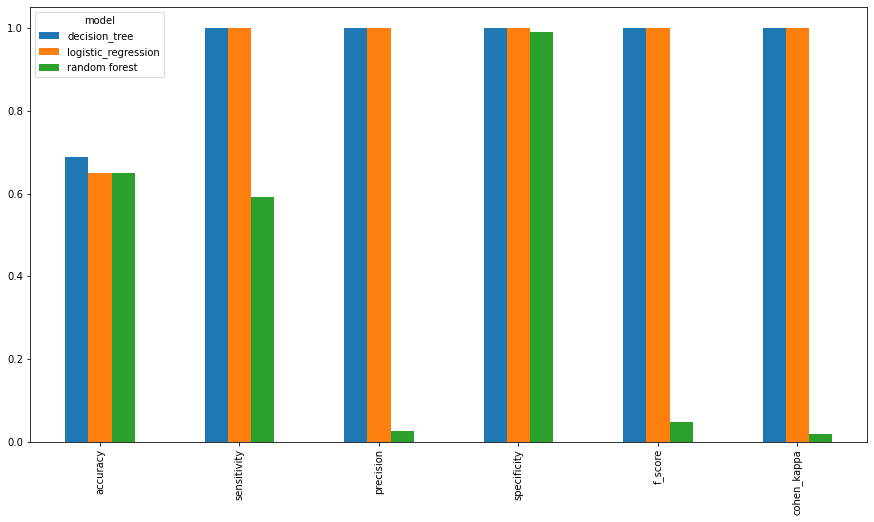

In [131]:
results.plot.bar(figsize=(15,8))